In [70]:
import scipy.io
import mne
import math
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal
from scipy.signal import spectrogram
from scipy.stats import entropy, skew
from scipy.linalg import toeplitz, cholesky

In [25]:
# 1. 导入MAT文件
mat_data = scipy.io.loadmat('data/indy_20161005_06.mat')

In [26]:
print(type(mat_data))
for k,v in mat_data.items():
    print(f"{k}，{type(v)}")

<class 'dict'>
__header__，<class 'bytes'>
__version__，<class 'str'>
__globals__，<class 'list'>
chan_names，<class 'numpy.ndarray'>
cursor_pos，<class 'numpy.ndarray'>
finger_pos，<class 'numpy.ndarray'>
spikes，<class 'numpy.ndarray'>
t，<class 'numpy.ndarray'>
target_pos，<class 'numpy.ndarray'>
wf，<class 'numpy.ndarray'>


In [27]:
# 提取数据
chan_names = mat_data['chan_names'].flatten()  #通道数96
chan_names=np.array([k[0] for k in chan_names])
cursor_pos = mat_data['cursor_pos']  #光标的位置
finger_pos = mat_data['finger_pos']  #指尖
spikes = mat_data['spikes']          #神经数据：unsorted/sorted
t = mat_data['t'].flatten()          #采样时间戳
target_pos = mat_data['target_pos']  #目标出现的xy
wf = mat_data['wf']                  #每个通道神经元发放波形

In [28]:
print(chan_names.shape)
print(cursor_pos.shape)
print(finger_pos.shape)
print(spikes.shape)
print(t.shape)
print(target_pos.shape)
print(wf.shape)

(96,)
(93501, 2)
(93501, 3)
(96, 5)
(93501,)
(93501, 2)
(96, 5)


<class 'numpy.ndarray'> (64,)


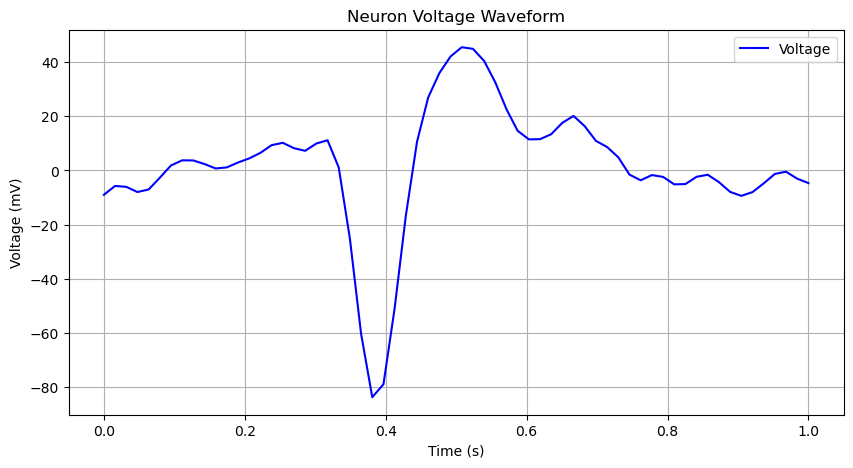

In [29]:
time = np.linspace(0, 1, 64)  # 生成从0到1秒的时间轴
voltage = wf[0,1][0,:]  # 

print(type(voltage),voltage.shape)
# # 创建电压波形图
plt.figure(figsize=(10, 5))
plt.plot(time, voltage, color='b', label='Voltage')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.title('Neuron Voltage Waveform')
plt.legend()
plt.grid()
plt.show()


(5,)
(1005, 1)


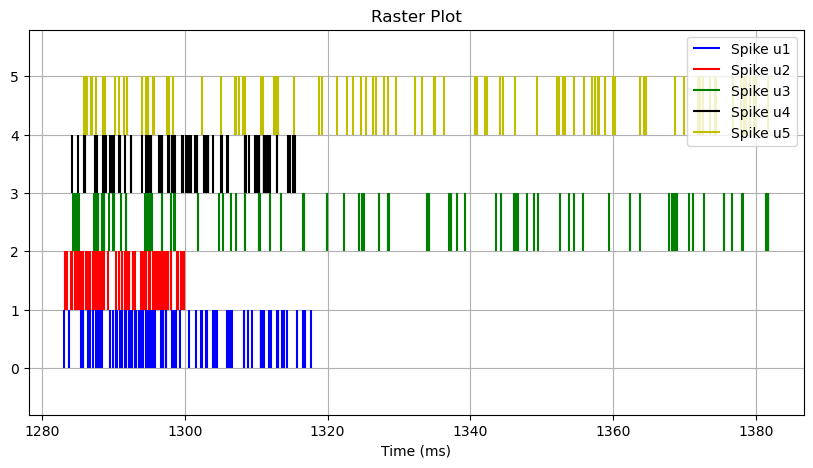

In [108]:
# 绘制Raster图
# 这只取了第二个通道的五个神经元的前30个时间点
spike_times=spikes[1,:].flatten()
print(spike_times.shape)
print(spike_times[0].shape)

plt.figure(figsize=(10, 5))

sample=100
plt.eventplot(spike_times[0].flatten()[0:sample], lineoffsets=0.5, colors='b', label='Spike u1')
plt.eventplot(spike_times[1].flatten()[0:sample], lineoffsets=1.5, colors='r', label='Spike u2')
plt.eventplot(spike_times[2].flatten()[0:sample], lineoffsets=2.5, colors='g', label='Spike u3')
plt.eventplot(spike_times[3].flatten()[0:sample], lineoffsets=3.5, colors='k', label='Spike u4')
plt.eventplot(spike_times[4].flatten()[0:sample], lineoffsets=4.5, colors='y', label='Spike u5')
plt.xlabel('Time (ms)')
plt.title('Raster Plot')
plt.legend()
plt.grid()
plt.show()

(1914,)
(76,) 1283.211975690231 1666.6133959934002


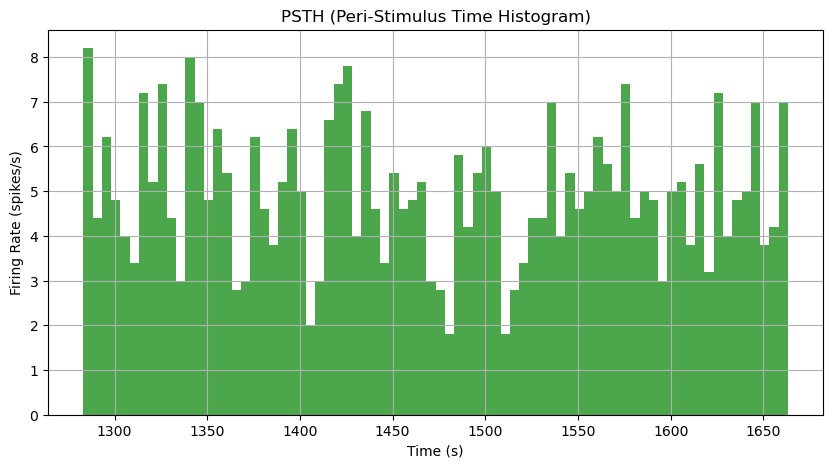

In [103]:
# 这里选取的是第二个通道的第二个神经元
# 创建PSTH图
psth_data=spike_times[1].flatten()
print(psth_data.shape)
bin_width = 5  # 每个时间窗口的宽度
bins = np.arange(min(psth_data),max(psth_data), bin_width)

hist, _ = np.histogram(psth_data, bins)
print(hist.shape,min(psth_data),max(psth_data))
hist = hist / bin_width  # 标准化为每秒的脉冲率

plt.figure(figsize=(10, 5))
plt.bar(bins[:-1], hist, width=bin_width, align='edge', color='g', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Firing Rate (spikes/s)')
plt.title('PSTH (Peri-Stimulus Time Histogram)')
plt.grid()
plt.show()

In [73]:
def get_gap(a,b):
    return math.sqrt((a[0]-b[0])**2+(a[1]-b[1])**2)

(1005,) (1914,)
(2919,) (434,)
(3353,) (1180,)
(4533,) (366,)


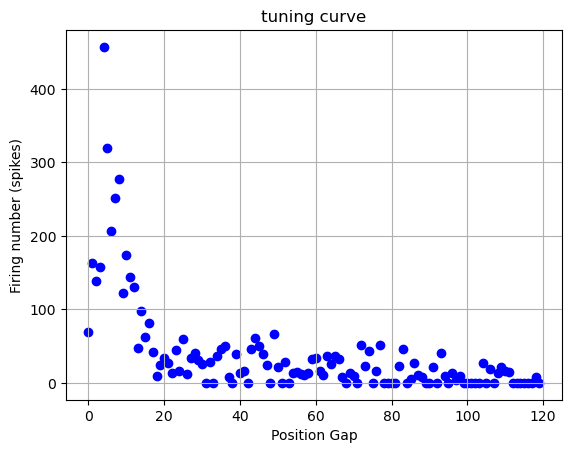

In [125]:
# 绘制神经元的 tuning curve
# 这里选取神经元tuning的位置参数，就是光标与目标的在笛卡尔坐标系中的距离
# 与第二个通道上，检测到的第二个神经元的脉冲发放速率
t_min=min(t)
t_max=max(t)
# 截取有位置标记的发射脉冲的时间段
time_data=spikes[1,:].flatten()[0].flatten()
for k in spikes[1,1:].flatten():
    print(time_data.shape,k.flatten().shape)
    time_data = np.concatenate((time_data,k.flatten()), axis=0)

time_data = time_data[(time_data>= t_min) & (time_data <= t_max)]

bin_width = 1  # 每个时间窗口的宽度
bins = np.arange(t_min,t_max+bin_width, bin_width)
hist, _ = np.histogram(time_data, bins)

index=np.array([key for key,value in enumerate(t) if abs(value-int(value))<1e-6 and key!=0])

# print(bins,hist)
# print(index.shape,hist.shape)

pos_gap=[get_gap(target_pos[i],cursor_pos[i]) for i in index]

# pos_gap=[target_pos[i][1]-cursor_pos[i][1] for i in index]
# hist=hist/len(hist)


stacked_array = np.stack((pos_gap, hist), axis=1)
# 获取排序后的索引
sorted_indices = np.argsort(stacked_array[:, 0])
# 使用索引对数组进行排序
sorted_data = stacked_array[sorted_indices]
# print(sorted_data)

rate_data=np.zeros(120)
num=np.zeros(120)
for v in sorted_data:
    rate_data[int(v[0])]+=v[1]
    num[int(v[0])]+=1
        

# 创建XY图
plt.scatter(range(len(rate_data)), rate_data, marker='o', color='b')

# 添加标签和标题
plt.xlabel('Position Gap')
plt.ylabel('Firing number (spikes)')
plt.title('tuning curve')


# 显示网格
plt.grid()

# 显示图形
plt.show()

# plt.scatter(range(len(rate_data)), rate_data/num, marker='o', color='b')

# # 添加标签和标题
# plt.xlabel('Position Gap')
# plt.ylabel('Firing Rate (spikes/s)')
# plt.title('tuning curve')


# # 显示网格
# plt.grid()

# # 显示图形
# plt.show()

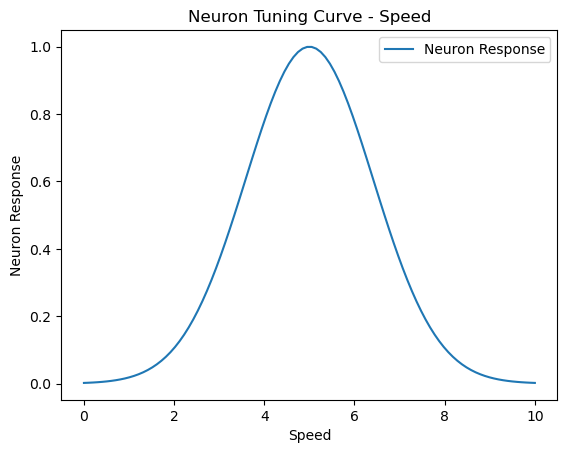

In [102]:
import numpy as np
import matplotlib.pyplot as plt

# 模拟数据
speeds = np.linspace(0, 10, 100)  # 速度范围
response_to_speed = np.exp(-(speeds - 5)**2 / 4)  # 模拟神经元对速度的响应

# 绘制速度tuning curve
plt.plot(speeds, response_to_speed, label='Neuron Response')
plt.title('Neuron Tuning Curve - Speed')
plt.xlabel('Speed')
plt.ylabel('Neuron Response')
plt.legend()
plt.show()


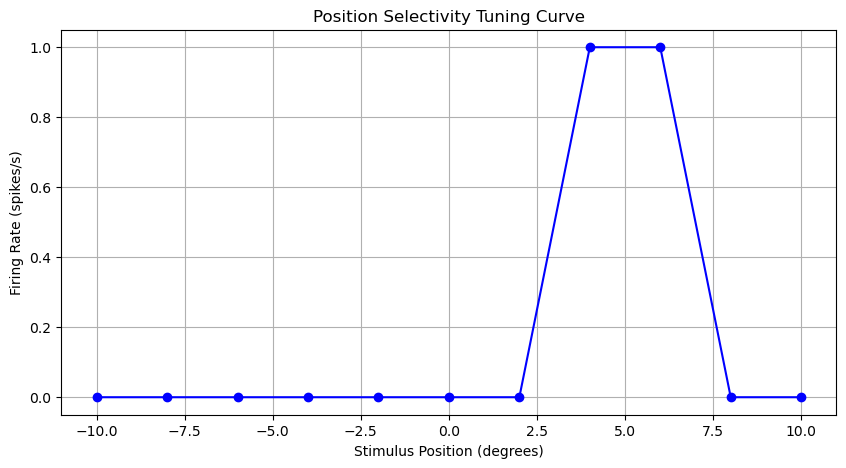

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# 模拟神经元的脉冲时间数据
spike_times = [5, 15, 25, 35, 45, 55, 65, 75, 85]

# 不同刺激位置
stimulus_positions = np.array([-10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10])

# 创建位置选择性的tuning curve
firing_rates = []

for position in stimulus_positions:
    # 在每个位置下计算在1秒内的脉冲率
    spikes_in_position = [spike for spike in spike_times if abs(spike - position) < 2]  # 2秒内的脉冲
    firing_rate = len(spikes_in_position) / 1.0  # 1秒内的脉冲率
    firing_rates.append(firing_rate)

# 创建tuning curve图
plt.figure(figsize=(10, 5))
plt.plot(stimulus_positions, firing_rates, marker='o', color='b')
plt.xlabel('Stimulus Position (degrees)')
plt.ylabel('Firing Rate (spikes/s)')
plt.title('Position Selectivity Tuning Curve')
plt.grid()
plt.show()
